In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

exp = "ExpA"

In [6]:
simulation_set_up = pd.read_csv(os.path.join("data", exp, "simulation_set_up.csv"))

In [10]:
simulation_set_up.columns

Index(['set_up', 'method', 'n_train', 'estimated_beta', 'file_name',
       'running_time', 'rep', 'n', 'trueProp1', 'true_beta', 'center_X', 'd',
       'corr', 'prcNA', 'prop1', 'pred_beta', 'angular_error', 'mse_error'],
      dtype='object')

In [32]:
def analyze_experimental_variance(df, metric="mse_error"):
    """
    Comprehensive analysis of variance sources in the experimental setup
    
    Parameters:
    df: pandas DataFrame
    metric: str, the column name of the performance metric to analyze
    """
    results = {}
    
    # 1. Basic summary statistics by factor
    factors = df.columns.tolist()
    remove_cols = ["set_up", "estimated_beta", "file_name", "running_time", "rep", "n", 
                  "trueProp1", "true_beta", "center_X", "d", "pred_beta", "angular_error", 
                  "mse_error"]
    # Remove the metric from remove_cols if it's in there
    if metric in remove_cols:
        remove_cols.remove(metric)
    
    # Get factors (excluding the metric and removed columns)
    factors = [f for f in factors if f not in remove_cols and f != metric]
    
    # Select columns to keep
    cols_to_keep = factors + ['rep', metric]
    df = df[cols_to_keep]
    
    # 1. Basic summary statistics by factor
    for factor in factors:  # Don't include metric in factors for groupby
        results[f'summary_{factor}'] = df.groupby(factor)[metric].agg([
            'mean', 'std', 'count',
            lambda x: stats.sem(x, ddof=len(x)-1)  # Standard error
        ]).rename(columns={'<lambda_0>': 'sem'})
    
    # 2. Variance Components Analysis
    # Fit a random effects model
    formula = f'{metric} ~ 1'
    try:
        vc_model = sm.MixedLM.from_formula(
            formula, 
            groups='rep',  # Use only rep as random effect
            data=df,
            re_formula='~1'
        )
        vc_results = vc_model.fit()
        results['variance_components'] = pd.DataFrame({
            'variance': [vc_results.cov_re.values[0,0]],
            'std_dev': [np.sqrt(vc_results.cov_re.values[0,0])]
        }, index=['rep'])
    except Exception as e:
        print(f"Warning: Variance components analysis failed with error: {str(e)}")
        
    # 4. Degrees of Freedom Analysis
    for factor in factors:
        n_groups = df[factor].nunique()
        n_replicates = df.groupby(factor)['rep'].nunique().mean()
        results[f'df_{factor}'] = {
            'n_groups': n_groups,
            'n_replicates': n_replicates,
            'df_between': n_groups - 1,
            'df_within': (n_replicates - 1) * n_groups
        }
    
    return results



simulation_set_up = simulation_set_up[simulation_set_up["method"] != "PbP"]
results = analyze_experimental_variance(simulation_set_up)


results

c:\Users\Chris\Anaconda3\envs\logistic\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


{'summary_method':                   mean       std  count       sem
 method                                           
 05.IMP        0.187890  0.228893    181  0.228260
 05.IMP.M      0.139803  0.209473    181  0.208894
 CC            0.127067  0.214892    181  0.214298
 ICE.IMP       0.152905  0.162760    181  0.162310
 ICE.IMP.M     0.152323  0.164132    181  0.163678
 ICEY.IMP      0.079308  0.199818    180  0.199263
 ICEY.IMP.M    0.079590  0.200735    180  0.200176
 MICE.5.IMP    0.080898  0.205178    180  0.204608
 MICE.IMP      0.096657  0.229063    183  0.228436
 MICE.M.IMP    0.156064  0.162162    180  0.161711
 MICE.Y.IMP    0.102281  0.265895    180  0.265155
 MICE.Y.M.IMP  0.113034  0.283365    180  0.282577
 Mean.IMP      0.142917  0.210227    181  0.209646
 Mean.IMP.M    0.139768  0.209448    181  0.208868
 SAEM          0.107039  0.286603    180  0.285806,
 'summary_n_train':              mean       std  count       sem
 n_train                                     
 50

In [34]:



def print_variance_analysis(results):
    """Print formatted analysis results"""
    print("=== Variance Analysis Results ===\n")
    
    print("1. Variance Components:")
    print(results['variance_components'])
    print("\n2. Degrees of Freedom Analysis:")
    for factor, df_info in results.items():
        if factor.startswith('df_'):
            print(f"\n{factor[3:].capitalize()}:")
            for k, v in df_info.items():
                print(f"  {k}: {v}")
    
    print("\n3. Standard Errors by Factor:")
    for factor in ['corr', 'prop1', 'prcNA', 'method', 'n_train']:
        print(f"\n{factor.capitalize()}:")
        print(results[f'summary_{factor}'][['mean', 'sem']])


print_variance_analysis(results)

=== Variance Analysis Results ===

1. Variance Components:
     variance   std_dev
rep  0.004848  0.069625

2. Degrees of Freedom Analysis:

Method:
  n_groups: 15
  n_replicates: 3.0
  df_between: 14
  df_within: 30.0

N_train:
  n_groups: 5
  n_replicates: 3.0
  df_between: 4
  df_within: 10.0

Corr:
  n_groups: 3
  n_replicates: 3.0
  df_between: 2
  df_within: 6.0

Prcna:
  n_groups: 2
  n_replicates: 3.0
  df_between: 1
  df_within: 4.0

Prop1:
  n_groups: 2
  n_replicates: 3.0
  df_between: 1
  df_within: 4.0

3. Standard Errors by Factor:

Corr:
          mean       sem
corr                    
0.00  0.054891  0.123138
0.65  0.084771  0.129134
0.95  0.232719  0.310088

Prop1:
           mean       sem
prop1                    
0.50   0.115078  0.212058
0.85   0.132730  0.228272

Prcna:
           mean       sem
prcNA                    
0.25   0.086736  0.163766
0.50   0.161282  0.260307

Method:
                  mean       sem
method                          
05.IMP        0.1

=== Variance Decomposition Summary ===

Variance Components:
rep: 0.0048 (100.0%)

Factor Level Summary:
method: 15 levels
n_train: 5 levels
corr: 3 levels
prcNA: 2 levels
prop1: 2 levels


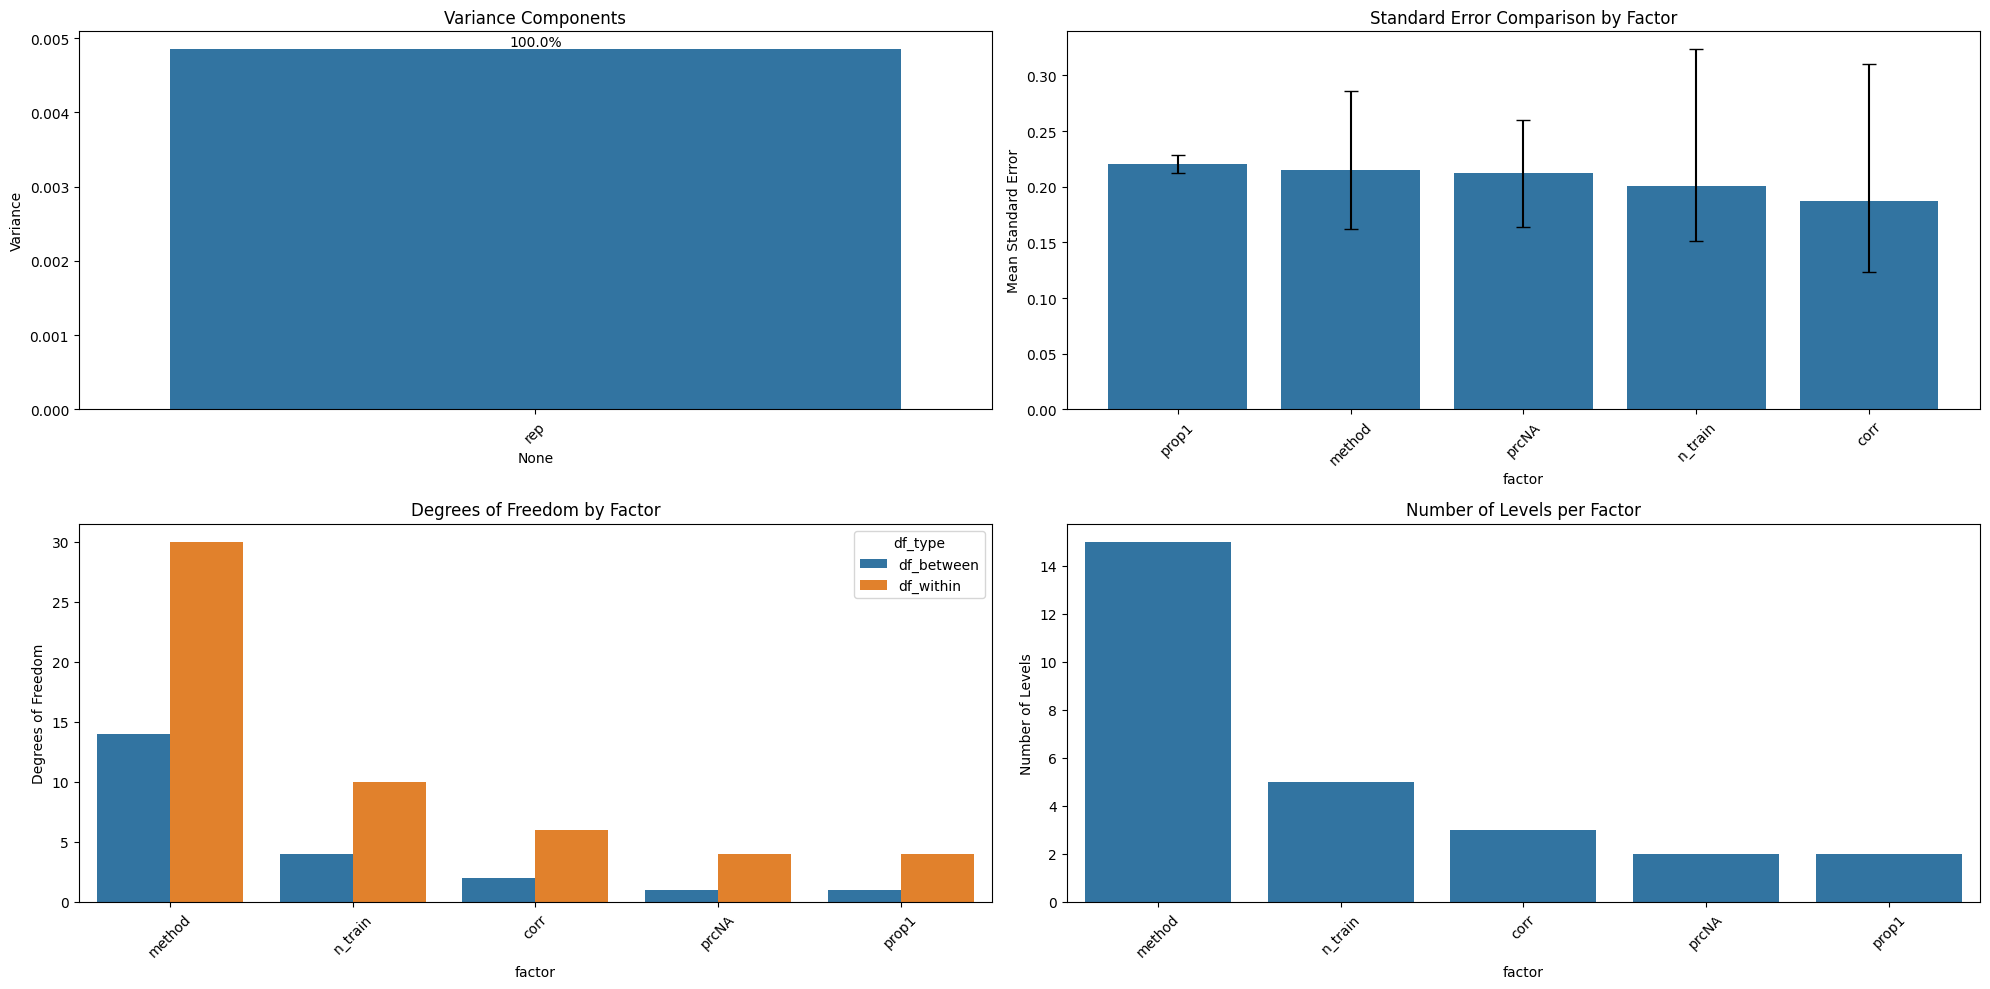

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_variance_decomposition(results):
    """
    Create comprehensive visualizations of variance decomposition from results summary
    
    Parameters:
    results: dict containing summary statistics and variance components
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Variance Components Barplot
    ax1 = fig.add_subplot(gs[0, 0])
    if 'variance_components' in results:
        vc_df = results['variance_components']
        sns.barplot(
            x=vc_df.index,
            y='variance',
            data=vc_df,
            ax=ax1
        )
        ax1.set_title('Variance Components')
        ax1.set_ylabel('Variance')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add percentage labels on top of bars
        total_var = vc_df['variance'].sum()
        for i, v in enumerate(vc_df['variance']):
            percentage = (v / total_var) * 100
            ax1.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')
    
    # 2. Standard Error Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    sem_data = []
    for key in results.keys():
        if key.startswith('summary_'):
            factor = key[8:]  # Remove 'summary_' prefix
            if isinstance(results[key], pd.DataFrame) and 'sem' in results[key].columns:
                factor_sem = results[key]['sem']
                sem_data.append({
                    'factor': factor,
                    'mean_sem': factor_sem.mean(),
                    'min_sem': factor_sem.min(),
                    'max_sem': factor_sem.max()
                })
    
    if sem_data:
        sem_df = pd.DataFrame(sem_data)
        sem_df = sem_df.sort_values('mean_sem', ascending=False)
        
        sns.barplot(
            x='factor',
            y='mean_sem',
            data=sem_df,
            ax=ax2
        )
        # Add error bars for min/max SEM
        ax2.errorbar(
            x=range(len(sem_df)),
            y=sem_df['mean_sem'],
            yerr=[sem_df['mean_sem'] - sem_df['min_sem'],
                  sem_df['max_sem'] - sem_df['mean_sem']],
            fmt='none',
            color='black',
            capsize=5
        )
        ax2.set_title('Standard Error Comparison by Factor')
        ax2.set_ylabel('Mean Standard Error')
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. Degrees of Freedom Comparison
    ax3 = fig.add_subplot(gs[1, 0])
    df_data = []
    for key in results.keys():
        if key.startswith('df_'):
            factor = key[3:]  # Remove 'df_' prefix
            df_info = results[key]
            df_data.append({
                'factor': factor,
                'df_between': df_info['df_between'],
                'df_within': df_info['df_within']
            })
    
    if df_data:
        df_df = pd.DataFrame(df_data)
        df_df_melted = pd.melt(
            df_df,
            id_vars=['factor'],
            var_name='df_type',
            value_name='degrees_of_freedom'
        )
        
        sns.barplot(
            x='factor',
            y='degrees_of_freedom',
            hue='df_type',
            data=df_df_melted,
            ax=ax3
        )
        ax3.set_title('Degrees of Freedom by Factor')
        ax3.set_ylabel('Degrees of Freedom')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4. Factor Level Counts
    ax4 = fig.add_subplot(gs[1, 1])
    level_counts = []
    for key in results.keys():
        if key.startswith('summary_'):
            factor = key[8:]  # Remove 'summary_' prefix
            if isinstance(results[key], pd.DataFrame):
                level_counts.append({
                    'factor': factor,
                    'n_levels': len(results[key])
                })
    
    if level_counts:
        level_df = pd.DataFrame(level_counts)
        sns.barplot(
            x='factor',
            y='n_levels',
            data=level_df,
            ax=ax4
        )
        ax4.set_title('Number of Levels per Factor')
        ax4.set_ylabel('Number of Levels')
        ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def print_variance_summary(results):
    """Print a text summary of the variance decomposition"""
    print("=== Variance Decomposition Summary ===\n")
    
    if 'variance_components' in results:
        print("Variance Components:")
        vc_df = results['variance_components']
        total_var = vc_df['variance'].sum()
        for idx, row in vc_df.iterrows():
            print(f"{idx}: {row['variance']:.4f} ({(row['variance']/total_var)*100:.1f}%)")
    
    print("\nFactor Level Summary:")
    for key in results.keys():
        if key.startswith('summary_'):
            factor = key[8:]
            if isinstance(results[key], pd.DataFrame):
                print(f"{factor}: {len(results[key])} levels")


print_variance_summary(results)
temp = visualize_variance_decomposition(results)

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from itertools import combinations

def compute_variance_decomposition(df, metric="mse_error", factors=None, max_interaction_level=2):
    """
    Compute variance decomposition for main effects and interactions
    
    Parameters:
    df: pandas DataFrame
    metric: str, name of the target variable
    factors: list of str, factors to include in analysis
    max_interaction_level: int, maximum level of interactions to consider
    
    Returns:
    DataFrame with variance components and their proportions
    """
    if factors is None:
        # Exclude the metric and numerical columns
        factors = [col for col in df.columns if col != metric and 
                  df[col].dtype == 'object' or df[col].dtype == 'category']
    
    # Initialize results storage
    variance_components = []
    total_ss = np.var(df[metric]) * (len(df) - 1)  # Total sum of squares
    
    # 1. Compute main effects
    for factor in factors:
        # Calculate Type III SS for this factor
        group_means = df.groupby(factor)[metric].mean()
        grand_mean = df[metric].mean()
        n_per_group = df.groupby(factor).size()
        
        ss_factor = np.sum(n_per_group * (group_means - grand_mean)**2)
        df_factor = len(group_means) - 1
        var_explained = ss_factor / total_ss
        
        variance_components.append({
            'effect_type': 'main',
            'factors': factor,
            'ss': ss_factor,
            'df': df_factor,
            'variance_proportion': var_explained,
            'mean_square': ss_factor / df_factor if df_factor > 0 else np.nan
        })
    
    # 2. Compute interactions up to specified level
    for level in range(2, max_interaction_level + 1):
        for factor_combo in combinations(factors, level):
            # Create interaction groups
            interaction_groups = df[list(factor_combo)].apply(lambda x: '_'.join(x.astype(str)), axis=1)
            
            # Calculate Type III SS for this interaction
            group_means = df.groupby(interaction_groups)[metric].mean()
            n_per_group = df.groupby(interaction_groups).size()
            
            # Calculate main effects contributions
            main_effects_mean = np.zeros(len(df))
            for factor in factor_combo:
                factor_means = df.groupby(factor)[metric].transform('mean')
                main_effects_mean += factor_means - grand_mean
            
            # Interaction SS
            ss_interaction = np.sum(n_per_group * (group_means - grand_mean - main_effects_mean.groupby(interaction_groups).mean())**2)
            df_interaction = (np.prod([df.groupby(f).ngroups for f in factor_combo]) - 1) - \
                           sum([df.groupby(f).ngroups - 1 for f in factor_combo])
            
            var_explained = ss_interaction / total_ss
            
            variance_components.append({
                'effect_type': f'{level}-way interaction',
                'factors': ' × '.join(factor_combo),
                'ss': ss_interaction,
                'df': df_interaction,
                'variance_proportion': var_explained,
                'mean_square': ss_interaction / df_interaction if df_interaction > 0 else np.nan
            })
    
    # Create DataFrame and sort by variance proportion
    results_df = pd.DataFrame(variance_components)
    results_df = results_df.sort_values('variance_proportion', ascending=False)
    
    # Calculate residual variance
    explained_variance = results_df['variance_proportion'].sum()
    residual_variance = 1 - explained_variance
    
    # Add residual row
    residual_row = pd.DataFrame([{
        'effect_type': 'residual',
        'factors': 'residual',
        'ss': total_ss * residual_variance,
        'df': len(df) - sum(results_df['df']),
        'variance_proportion': residual_variance,
        'mean_square': (total_ss * residual_variance) / (len(df) - sum(results_df['df']))
    }])
    
    results_df = pd.concat([results_df, residual_row], ignore_index=True)
    
    return results_df

def plot_variance_decomposition(results_df):
    """
    Create visualization of variance decomposition
    """
    plt.figure(figsize=(12, 6))
    
    # Create barplot
    bars = plt.bar(range(len(results_df)), 
                  results_df['variance_proportion'],
                  alpha=0.8)
    
    # Customize plot
    plt.xticks(range(len(results_df)), 
               results_df['factors'], 
               rotation=45, 
               ha='right')
    plt.ylabel('Proportion of Variance Explained')
    plt.title('Variance Decomposition')
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()



# Compute variance decomposition
results_df = compute_variance_decomposition(simulation_set_up, metric='mse_error', factors=['corr', 'prop1', 'prcNA', 'method', 'n_train'])


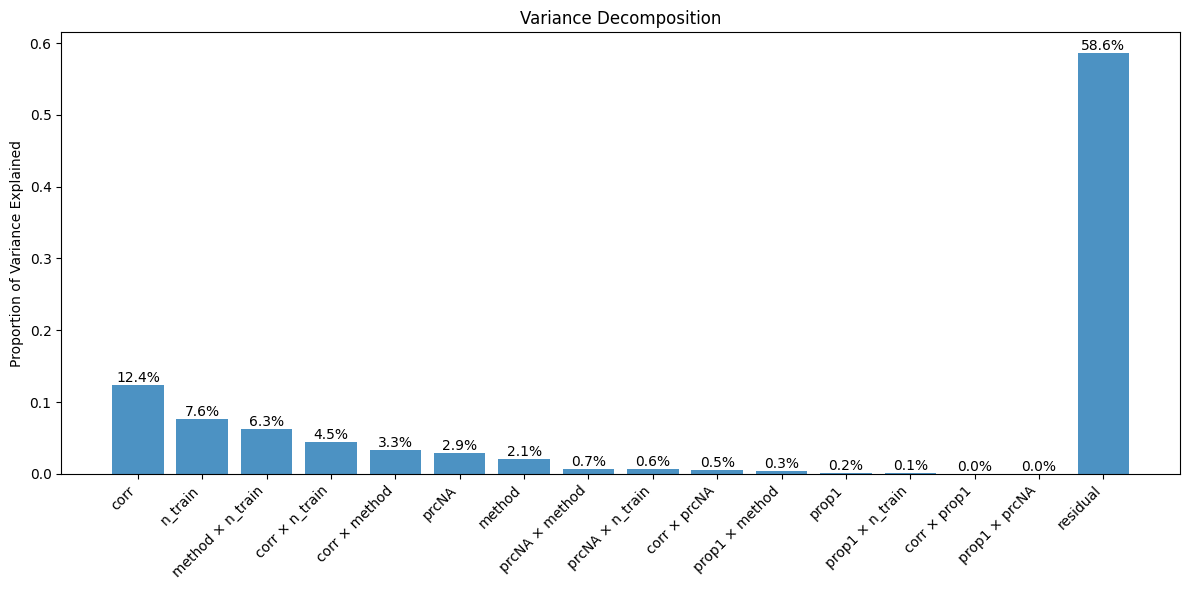

In [44]:
t = plot_variance_decomposition(results_df)